In [38]:
!pip install category_encoders
!pip install catboost
!pip install shap

     |████████████████████████████████| 358kB 6.5MB/s 
  Created wheel for shap: filename=shap-0.38.1-cp36-cp36m-linux_x86_64.whl size=489393 sha256=d8eb74d32d1ac90ebde20d2a33e27b85f3692b3f9e6e0d8edd97f62ec8c0184e
  Stored in directory: /root/.cache/pip/wheels/a8/fb/e4/88012be41842b9be62ae18d82d1b1e880daf8539d1fef1fa00
Successfully built shap


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

In [3]:
train=pd.read_csv('/content/drive/MyDrive/colab전용/data13/train.csv')
test=pd.read_csv('/content/drive/MyDrive/colab전용/data13/test.csv')

In [4]:
display(train.head())
display(train.shape)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


(415423, 21)

In [5]:
def datainfo(df):
    return pd.DataFrame([(col,df[col].nunique(),df[col].dtype,df[col].isna().sum(),
                          df[col].unique()[:5]) for col in df.columns],
                         columns=['name','nunique','dtype','missing','value :5'])
    
datainfo(train)

,name,nunique,dtype,missing,value :5
0,id,415423,int64,0,"[0, 1, 2, 3, 4]"
1,date,30,object,0,"[2019-09-01, 2019-09-02, 2019-09-03, 2019-09-0..."
2,bus_route_id,613,int64,0,"[4270000, 4280000, 8170000, 8180000, 17010000]"
3,in_out,2,object,0,"[시외, 시내]"
4,station_code,3563,int64,0,"[344, 357, 432, 1579, 1646]"
5,station_name,1961,object,0,"[제주썬호텔, 한라병원, 정존마을, 제주국제공항(600번), 중문관광단지입구]"
6,latitude,3278,float64,0,"[33.4899, 33.48944, 33.48181, 33.50577, 33.255..."
7,longitude,3446,float64,0,"[126.49373, 126.48508, 126.47352, 126.49252, 1..."
8,6~7_ride,47,float64,0,"[0.0, 1.0, 2.0, 4.0, 8.0]"
9,7~8_ride,80,float64,0,"[1.0, 4.0, 17.0, 0.0, 2.0]"


In [6]:
categorical_cols=train.select_dtypes(include='object').columns
numerical_cols=[col for col in train.columns if col not in categorical_cols]

display(categorical_cols)
display(numerical_cols)

Index(['date', 'in_out', 'station_name'], dtype='object')

['id',
 'bus_route_id',
 'station_code',
 'latitude',
 'longitude',
 '6~7_ride',
 '7~8_ride',
 '8~9_ride',
 '9~10_ride',
 '10~11_ride',
 '11~12_ride',
 '6~7_takeoff',
 '7~8_takeoff',
 '8~9_takeoff',
 '9~10_takeoff',
 '10~11_takeoff',
 '11~12_takeoff',
 '18~20_ride']

In [7]:
train[categorical_cols].describe()

,date,in_out,station_name
count,415423,415423,415423
unique,30,2,1961
top,2019-09-19,시내,한라병원
freq,16030,408500,3125


1. train의 9월로 test의 10월을 예측. -> date 함수 뺀다. 
1-1. 날짜데이터는 무조건 쓴다? 주말도 빼보고 
2. 위.경도 문자열로 합친다.
3. ~~위.경도 다른데 station_name 같다.? -> 길건녀편으로 이름 바꾼다.~~ 필요없다. 
4. 내생각인데 버스가 많이 내리는곳에서 많이탈수도있고, 많이 안탈수도있다고 생각했다.그래서 takeoff 버리고 한번 해보는것도 괜찮을것같다. columns
5. 카테고리를 category_encoders로 바꾸고.~~ pycaret으로 해보려고 한다. -> pycaret의 columns을 읽어들이는게 알아서 잘 순서없는 카테고리로 알아듣는것같다.~~ pycaret 안된다. 왜 안되는지는 모르겠다. 
6. 만약 가능하다면 shap 배운걸로 몇몇 columns들 잘 조작해서 모델을 일반화해보는 과정도 해봐야겠다.

In [8]:
train['date']=pd.to_datetime(train['date'],format='%Y-%m-%d')
test['date']=pd.to_datetime(test['date'],format='%Y-%m-%d')
train['weekday']=train['date'].dt.weekday
test['weekday']=test['date'].dt.weekday

In [9]:
import holidays

korea=holidays.Korea()

# 공휴일과 평일과 주말
train['holiday']=train['date'].apply(lambda x:x in korea).astype(int)
train['weekday']=train['date'].dt.weekday
train['wday']=train['weekday'].apply(lambda x:1 if x<5 else 0)

test['holiday']=test['date'].apply(lambda x:x in korea).astype(int)
test['weekday']=test['date'].dt.weekday
test['wday']=test['weekday'].apply(lambda x:1 if x<5 else 0)

In [10]:
train['location']=train['latitude'].astype(str)+'#'+train['longitude'].astype(str)
test['location']=test['latitude'].astype(str)+'#'+test['longitude'].astype(str)

In [11]:
# 버리기
drop_cols=['id','date','station_name','station_code','station_name','latitude','longitude']+\
[col for col in train.columns if 'takeoff' in col]
train=train.drop(drop_cols,axis=1)
test=test.drop(drop_cols,axis=1)

In [12]:
from category_encoders.ordinal import OrdinalEncoder

oe=OrdinalEncoder()
oe.fit(train['bus_route_id'].astype(str))

train['bus_route_id']=oe.transform(train['bus_route_id'].astype(str))
test['bus_route_id']=oe.transform(test['bus_route_id'].astype(str))

test['bus_route_id']=test['bus_route_id'].astype(int)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [14]:
# in_out
oe=OrdinalEncoder()
oe.fit(train['in_out'].astype(str))

train['in_out']=oe.transform(train['in_out'].astype(str))
test['in_out']=oe.transform(test['in_out'].astype(str))

test['in_out']=test['in_out'].astype(int)

# location
oe=OrdinalEncoder()
oe.fit(train['location'].astype(str))

train['location']=oe.transform(train['location'].astype(str))
test['location']=oe.transform(test['location'].astype(str))

test['location']=test['location'].astype(int)

In [26]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train,X_valid,y_train,y_valid=train_test_split(train.drop('18~20_ride',axis=1),train['18~20_ride'],test_size=0.2,random_state=71)

lgb_params={'random_state':71,'seed':71}
xgb_params={'random_state':71,'seed':71}
cat_params={'random_seed':71}

lgb_model=LGBMRegressor(**lgb_params)
xgb_model=XGBRegressor(**xgb_params)
cat_model=CatBoostRegressor(**cat_params)

lgb_model.fit(X_train,y_train)
lgb_val=lgb_model.predict(X_valid)
xgb_model.fit(X_train,y_train)
xgb_val=xgb_model.predict(X_valid)
cat_model.fit(X_train,y_train)
cat_val=cat_model.predict(X_valid)

lgb_score=np.sqrt(mean_squared_error(lgb_val,y_valid))
xgb_score=np.sqrt(mean_squared_error(xgb_val,y_valid))
cat_score=np.sqrt(mean_squared_error(cat_val,y_valid))

print(f"lgb_score : {lgb_score}, xgb_score : {xgb_score}, cat_score : {cat_score}")

[LightGBM] [Warning] seed is set=71, random_state=71 will be ignored. Current value: seed=71
Learning rate set to 0.109709
0:	learn: 4.5221672	total: 124ms	remaining: 2m 3s
1:	learn: 4.3623285	total: 179ms	remaining: 1m 29s
2:	learn: 4.2283535	total: 226ms	remaining: 1m 14s
3:	learn: 4.1123634	total: 269ms	remaining: 1m 7s
4:	learn: 4.0149616	total: 314ms	remaining: 1m 2s
5:	learn: 3.9303042	total: 358ms	remaining: 59.3s
6:	learn: 3.8574979	total: 407ms	remaining: 57.7s
7:	learn: 3.7965212	total: 456ms	remaining: 56.5s
8:	learn: 3.7178420	total: 505ms	remaining: 55.6s
9:	learn: 3.6735201	total: 550ms	remaining: 54.5s
10:	learn: 3.6345275	total: 598ms	remaining: 53.8s
11:	learn: 3.5831720	total: 650ms	remaining: 53.5s
12:	learn: 3.5538030	total: 694ms	remaining: 52.7s
13:	learn: 3.5252372	total: 740ms	remaining: 52.1s
14:	learn: 3.5001128	total: 791ms	remaining: 52s
15:	learn: 3.4775398	total: 837ms	remaining: 51.5s
16:	learn: 3.4557152	total: 888ms	remaining: 51.4s
17:	learn: 3.4385745

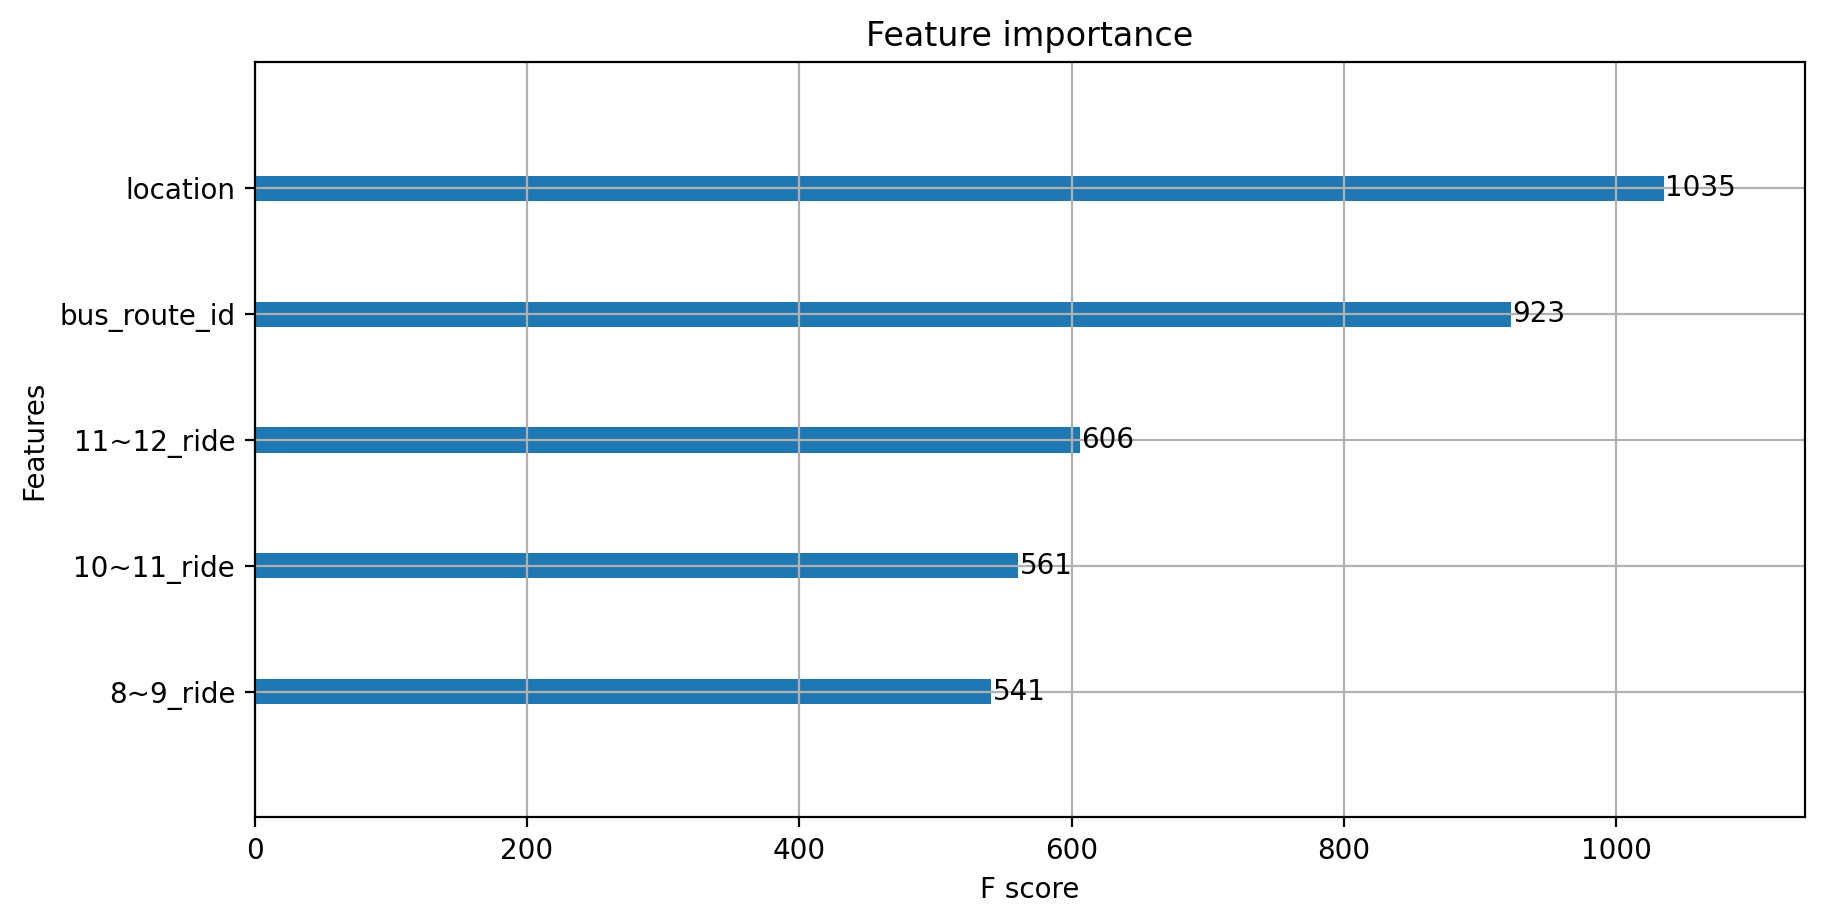

In [36]:
# location이 중요할것이라는 가설 맞았다.
# bus_route_id 도 category로 만든게 컸다.
import xgboost as xgb

fig,ax=plt.subplots(1,1,figsize=(10,5),dpi=200)

xgb.plot_importance(xgb_model,max_num_features=5,ax=ax)

plt.show()

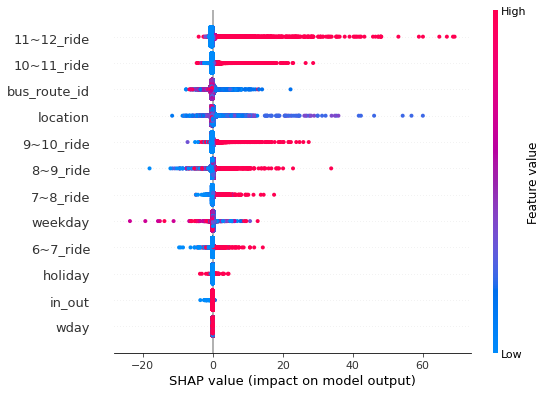

In [41]:
# location이나 bus_route_id 등 같은 거는 카테고리라 별로 없는데
# 11~12_ride들의 큰 값들이 ??
# location의 낮은 값들이 기여도가 컸다는 뜻이다.

import shap

explainer=shap.TreeExplainer(xgb_model)
shap_values=explainer.shap_values(X_valid[X_valid.columns])
shap.summary_plot(shap_values,X_valid[X_valid.columns])

In [27]:
lgb_pred=lgb_model.predict(test)
xgb_pred=xgb_model.predict(test)
cat_pred=cat_model.predict(test)

display(lgb_pred)

array([ 5.99086956, 10.29701947,  3.9526975 , ...,  0.31335694,
        0.31367124,  0.25862241])

In [29]:
submission=pd.read_csv('/content/drive/MyDrive/colab전용/data13/submission_sample.csv')

In [31]:
pred=lgb_pred*0.3+xgb_pred*0.4+cat_score*0.3
submission['18~20_ride']=pred

submission.head()

,id,18~20_ride
0,415423,5.627761
1,415424,8.315887
2,415425,2.813311
3,415426,35.205170
4,415427,1.180486


In [32]:
# submission.to_csv('/content/drive/MyDrive/colab전용/20210127_lgb0.3_xgb0.4_cat0.3.csv',index=False)